# CS933 Image & Video Analysis coursework 2023-2024, Part 1
> ID: 5556162, Name: Tien Yu Lin

## Module imports

In [1]:
from lib.public import (
    db,
    plt,
    measure,
    np,
    find_bounding_box_from,
    cv2,
    show_images_in_row,
    find_principal_axes_from,
    find_centroid_from,
)

## Resistor 1 and 2 (Synthetic Images)

In [2]:
def find_resistor_single_components(resistor_num: int) -> [np.ndarray, ...]:
    _resistor = cv2.imread(f'{db.resistor_dir}/RESISTORS-{resistor_num}.png')

    gray_resistor = cv2.cvtColor(_resistor, cv2.COLOR_BGR2GRAY)

    threshed_resistors = np.zeros(gray_resistor.shape, np.uint8)
    threshed_resistors[gray_resistor < 245] = 1

    labeled_resistors_set = measure.label(threshed_resistors, background=0)

    labels_of_resistors = np.unique(labeled_resistors_set)

    min_size = 100

    separated_resistors: [np.ndarray] = []
    separated_resistors_binary: [np.ndarray] = []

    # Skip the first label, which is the background.
    for the_label in labels_of_resistors[1:]:
        left, top, right, bottom = find_bounding_box_from(
            labeled_resistors_set,
            label=the_label
        )

        # separate each resistor into single image.
        # create a shape=3 zero array, and set the target resistor to 1
        target_component = np.full_like(_resistor, 255)
        target_component_binary = np.zeros_like(gray_resistor)
        
        # Copy the target resistor to the target_component array
        target_component[labeled_resistors_set == the_label] = _resistor[labeled_resistors_set == the_label]
        target_component_binary[labeled_resistors_set == the_label] = 1
        
        # cut the target component image size to the size of the resistor
        target_component = target_component[top:bottom, left:right]
        target_component_binary = target_component_binary[top:bottom, left:right]

        # measure its size
        n = np.count_nonzero(target_component)

        # plot as image if it's big enough (greater than min_size)
        if n > min_size:
            separated_resistors.append(cv2.cvtColor(target_component, cv2.COLOR_BGR2RGB))
            separated_resistors_binary.append(target_component_binary)

    # Show each resistor in a grid
    show_images_in_row(separated_resistors)
    return separated_resistors, separated_resistors_binary

### Find single components of resistor

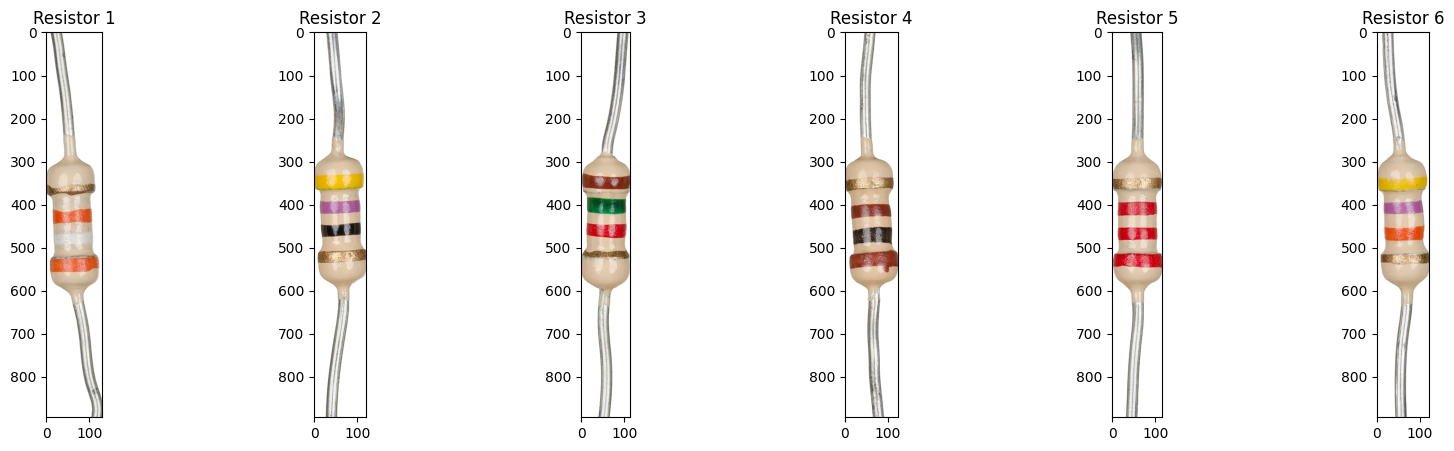

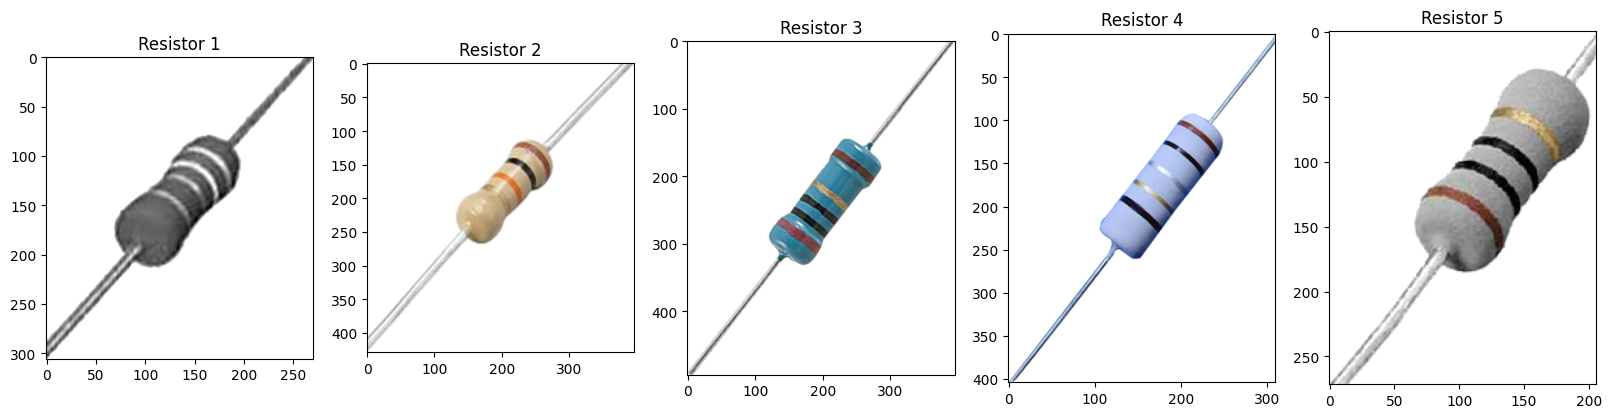

In [3]:
r1_resistors, b_r1_resistors = find_resistor_single_components(1)
r2_resistors, b_r2_resistors = find_resistor_single_components(2)

### Find the central line of each resistor

In [4]:
# The central line of a resistor is the line that is parallel to the resistor's body.
# It is the line that is in the middle of a resistor.

def central_line_of(img: np.ndarray) -> np.ndarray:
    if len(img.shape) > 2:
        raise ValueError('The input image should be a grayscale image.')
    
    return find_principal_axes_from(img)

def draw_central_line_on(
        img: np.ndarray,
        /,
        *,
        a: [float, float], 
        b: [float, float]
) -> np.ndarray:
    return cv2.line(
        img,
        (int(a[0]), int(a[1])),
        (int(b[0]), int(b[1])),
        (0, 0, 255),
        2
    )

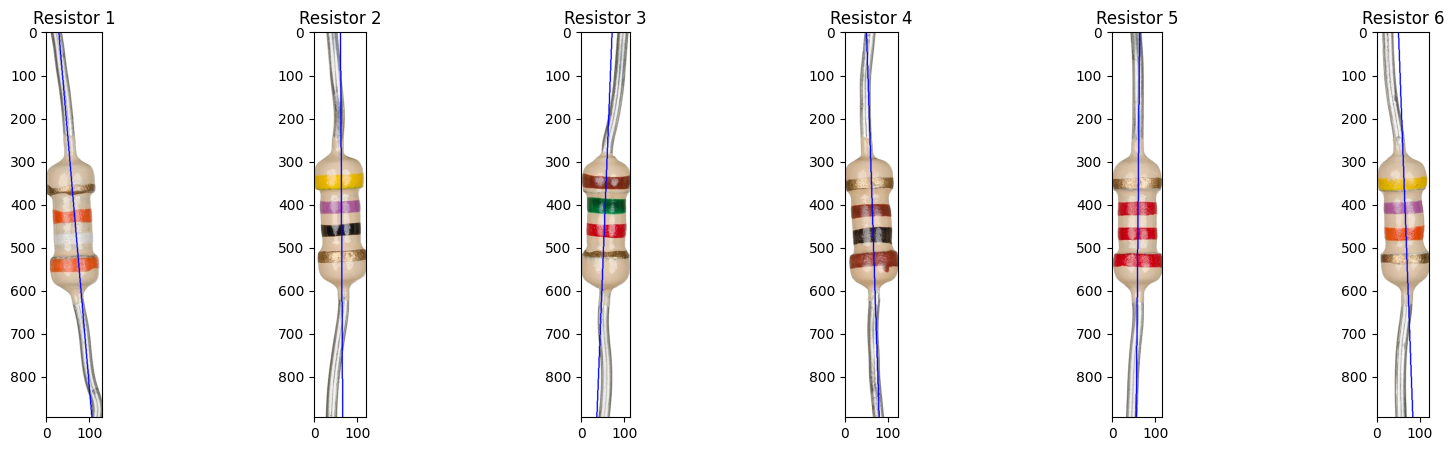

In [5]:
r1_with_central_line = []

for i, resistor in enumerate(r1_resistors):
    central_line = central_line_of(b_r1_resistors[i])
    # Flip the central line horizontally to make it parallel to the resistor's body
    central_line[0][0] = resistor.shape[1] - central_line[0][0]
    central_line[1][0] = resistor.shape[1] - central_line[1][0]
    
    r1_with_central_line.append(draw_central_line_on(resistor, a=central_line[0], b=central_line[1]))

show_images_in_row(r1_with_central_line)

In [6]:
# Crop the resistor 2 images to a fixed size.
# It should base on the central point of the image.

crop_size_x = 200
crop_size_y = 200

def crop_resistor_to_fixed_size(resistor_: np.ndarray) -> np.ndarray:
    # Find the central point of the resistor
    # If the image is RGB, convert it to grayscale first.
    if len(resistor_.shape) > 2:
        resistor_tmp = cv2.cvtColor(resistor_, cv2.COLOR_BGR2GRAY)
    else:
        resistor_tmp = resistor_.copy()
    central_point = find_centroid_from(resistor_tmp)
    
    half_crop_size_x = crop_size_x // 2
    half_crop_size_y = crop_size_y // 2

    # Crop the resistor to a fixed size
    return resistor_[
        int(central_point[1] - half_crop_size_y):int(central_point[1] + half_crop_size_y),
        int(central_point[0] - half_crop_size_x):int(central_point[0] + half_crop_size_x)
    ]

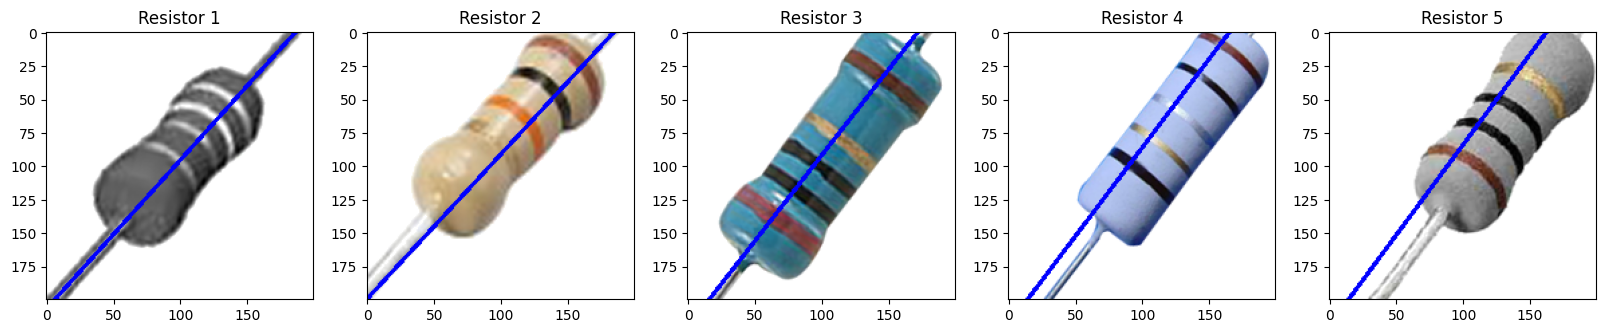

In [7]:
r2_resistors = [crop_resistor_to_fixed_size(resistor) for resistor in r2_resistors]
b_r2_resistors = [crop_resistor_to_fixed_size(resistor) for resistor in b_r2_resistors]

r2_with_central_line = []

for i, resistor in enumerate(r2_resistors):
    central_line = central_line_of(b_r2_resistors[i])
    # Flip the central line horizontally to make it parallel to the resistor's body
    central_line[0][0] = resistor.shape[1] - central_line[0][0]
    central_line[1][0] = resistor.shape[1] - central_line[1][0]
    
    r2_with_central_line.append(draw_central_line_on(resistor, a=central_line[0], b=central_line[1]))

show_images_in_row(r2_with_central_line)

## Resistor 3 (Real World Image)

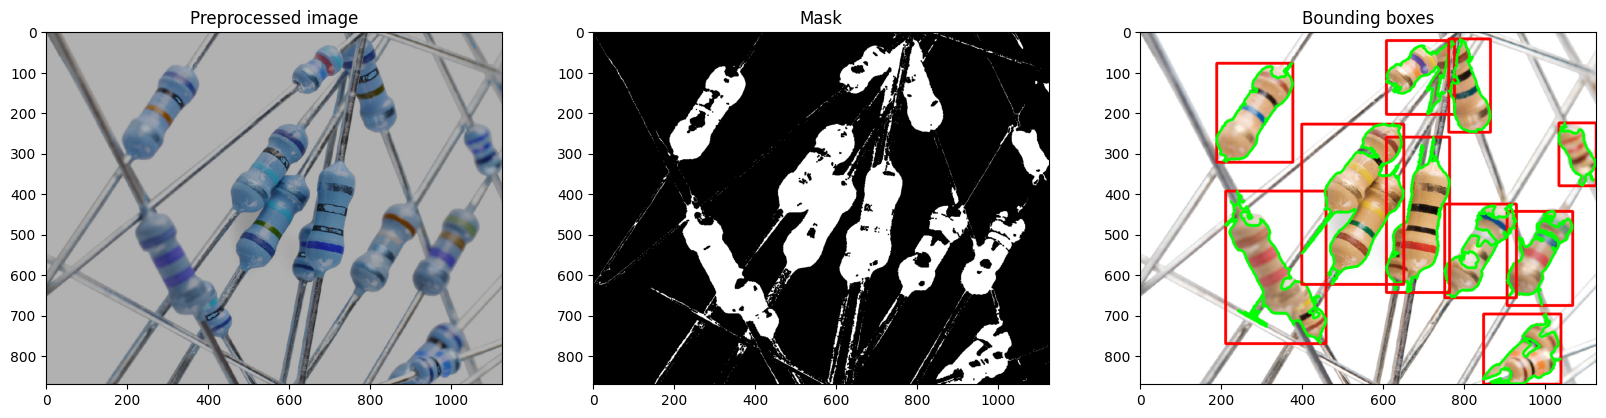

In [8]:
# Note that using opencv to read the image will result in BGR format
origin_r3 = cv2.imread(f'{db.resistor_dir}/RESISTORS-3.png')
r3 = origin_r3.copy()

beige_bgr = (117, 174, 220)

# Create a 1x3 subplot with labels
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

"""
Step 1, Preprocessing
Change some specific colors so that makes the image easier to be masked.
"""

# Lighten areas which nearly black, not just black
# This is because some bands on the beige of a resistor are black,
# However, some parts of the resistor conduct lines are also black.
# If we don't lighten the black color, we may not able to change them into beige's color by just using the threshold in HSV color space.
is_near_black = (r3[:, :, 0] < 40) & (r3[:, :, 1] < 40) & (r3[:, :, 2] < 40)
r3[is_near_black] = beige_bgr

# Changing the color of area which nearly gray.
# Since the background of the whole image is white, 
# and some of the bands on the beige of a resistor are also white, 
# we need to accurately change the color of the bands on the beige of a resistor to beige's color, 
# otherwise those gray bands will become empty gap,
# after we change all the bands' color to beige.
is_near_gray = (
        (r3[:, :, 0] > 150) & (r3[:, :, 2] < 190) &
        (r3[:, :, 1] > 170) & (r3[:, :, 1] < 185) &
        (r3[:, :, 2] > 180) & (r3[:, :, 0] < 190)
)
r3[is_near_gray] = beige_bgr

# Decrease the brightness of the image for better color conversion
r3 = cv2.convertScaleAbs(r3, alpha=-0.7, beta=1.2)

# Show current r3 image in the first subplot with label
axs[0].imshow(r3)
axs[0].set_title('Preprocessed image')

"""
Step 2, Edge detection
Try to find edges of each resistor for helping us to separate resistors.
"""

# For finding edges, we need to use grayscale image.
r3_gray = cv2.cvtColor(r3, cv2.COLOR_BGR2GRAY)

# Apply GaussianBlur to reduce noise for edge detection
blurred = cv2.GaussianBlur(r3_gray, (19, 19), 0)

# Find edges in the image using the Canny edge detector
edges = cv2.Canny(blurred, 19, 50)

# Dilate the edges to make them thicker
dilated_edges = cv2.dilate(edges, np.ones((1, 1), np.uint8), iterations=2)

# Put edges onto the original image, and make edges white
r3[dilated_edges > 0] = (255, 255, 255)

"""
Step 3, Masking
Convert the color of bands on the beige of a resistor to beige's color.
"""

# Use HSV color space to avoid the influence of brightness, e.g. reflection.
hsv_r3 = cv2.cvtColor(r3, cv2.COLOR_BGR2HSV)

# Assuming beige and silver (the body and the ends of the resistors) are not to be masked,
# we create a mask for all other colors which would be the color bands
mask_lower = np.array([0, 50, 50])
mask_upper = np.array([179, 255, 255])

y_mask = cv2.inRange(hsv_r3, mask_lower, mask_upper)
bands_mask = cv2.bitwise_not(y_mask)

# Now, convert all colored bands to beige color (approximately)
r3[np.where(bands_mask == 0)] = beige_bgr

# Define range for the beige color of resistor bodies in HSV
beige_lower = np.array([15, 40, 100])
beige_upper = np.array([50, 255, 255])

# Convert the image (with band masks) to HSV color space
hsv_r3 = cv2.cvtColor(r3, cv2.COLOR_BGR2HSV)

# Threshold the HSV image to get only beige colors
mask = cv2.inRange(hsv_r3, beige_lower, beige_upper)

# Use morphological operations to close gaps in the mask
kernel = np.ones((3, 3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

# Show the mask in the second subplot
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Mask')

"""
Step 4, Bounding boxes
Find bounding boxes of each resistor.
"""

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours by area (this depends on the image resolution and size of resistors)
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 850]

# Draw bounding boxes around detected resistor bodies
r3_for_display = origin_r3.copy()
min_contour_area = 6400  # minimum contour area to be considered
for cnt in filtered_contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(r3_for_display, (x, y), (x + w, y + h), (0, 0, 255), 6)
    if cv2.contourArea(cnt) > min_contour_area:
        cv2.drawContours(r3_for_display, [cnt], 0, (0, 255, 0), 6)

# Show the bounding boxes in the third subplot
axs[2].imshow(cv2.cvtColor(r3_for_display, cv2.COLOR_BGR2RGB))
axs[2].set_title('Bounding boxes')

plt.show()

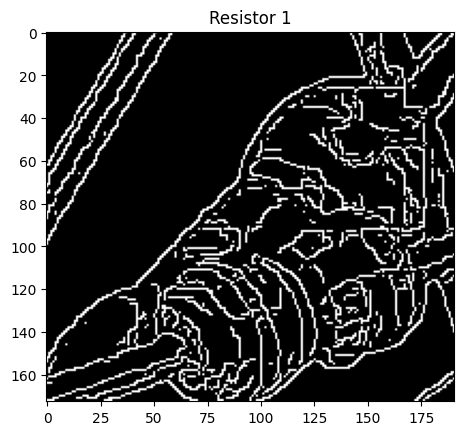

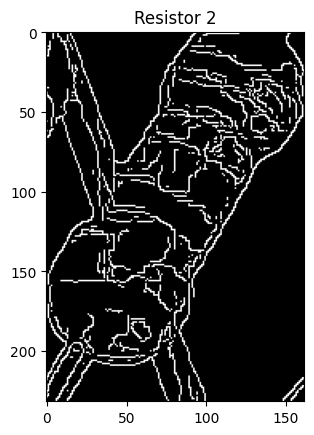

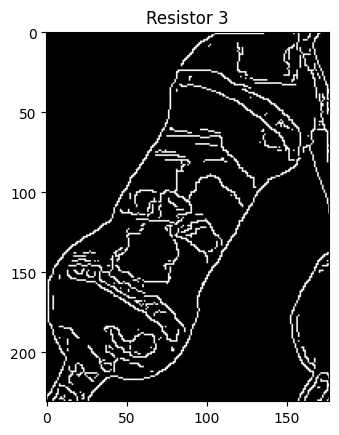

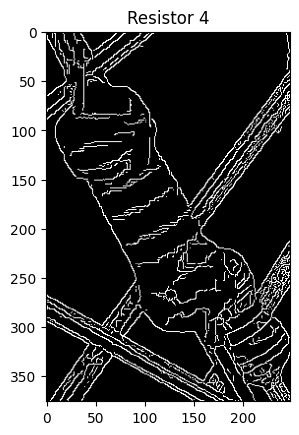

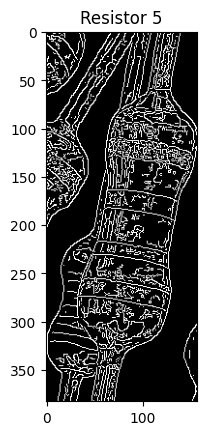

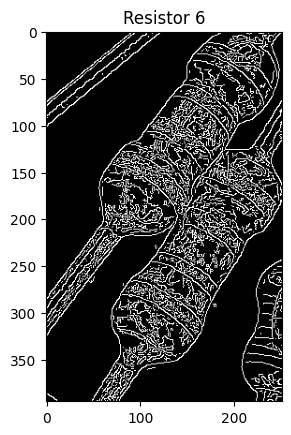

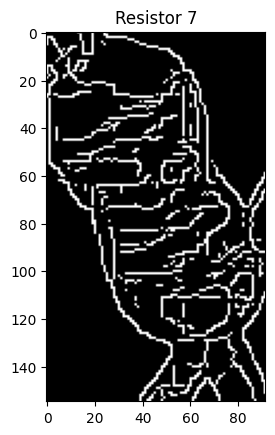

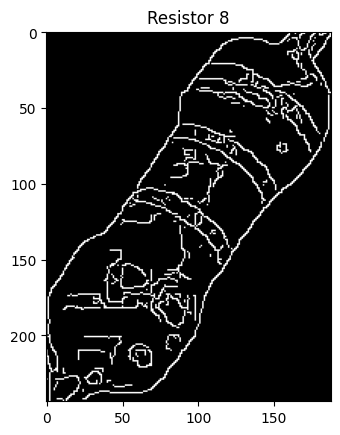

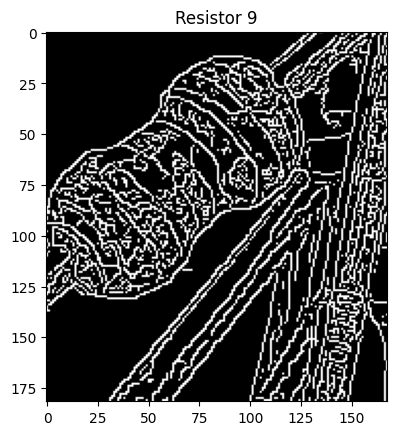

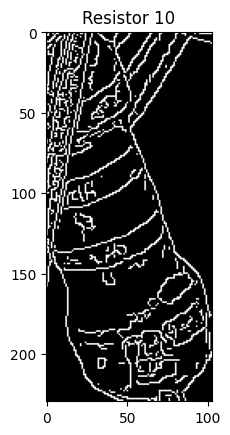

In [9]:
# Convert mask to binary image
mask[mask > 0] = 1
labeled_r3_set = measure.label(mask, background=0)
labels_of_r3_resistors = np.unique(labeled_r3_set)

# Show each resistor in a separate image
for i, cnt in enumerate(filtered_contours):
    x, y, w, h = cv2.boundingRect(cnt)
    resistor = origin_r3[y:y + h, x:x + w]
    edges = cv2.Canny(resistor, 19, 50, apertureSize=3, L2gradient=True)

    plt.imshow(edges, cmap='gray')
    plt.title(f'Resistor {i + 1}')
    plt.show()